###Trilateration and picking landmarks

Trilateration is like triangulation, but uses the distances to landmarks, rather than their angles, to determine one's location. GPS is probably the most common example of trilateration in use at the moment.

In our problem we have a set of landmarks. We know the distance (with some uncertainty) to one, and we want to know which of the remaining landmarks we should select next to maximise the amount of information we gain about our location.

For our particular example, we ask people to estimate the distance of various landmarks from their house.

Assumptions:

 - We assume here that the uncertainty in a person's estimate is Normally distributed and proportional ($\alpha$) to the distance they have given.
 
 - We are only considering the 2d situation.

 - The answer will often be different if we are looking for the set of N landmarks which might maximise information (the algorithm is effectively greedy by selecting one landmark at a time).

Notes:

 - Some of the functions can be optimised considerably, by sampling just subsets of distributions (currently looking at the whole of P(X) for example).

In [41]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Calculates over the grid of cells, defined by the vectors X and Y,
#the 'donut' of probability that defines the likely location of the
#person, given that they are 'radius' distance from a landmark at
#location centreX, centreY.
#width is the standard deviation of the distribution of the error on
#their estimate.
def donut(X,Y,centreX,centreY,radius,width):
    import scipy.stats
    radiussqr = radius**2;
    twowidthsqr = 2*width**2;
    normalising = 1./(width*np.sqrt(2.*np.pi));
    Z = np.zeros_like(X)
    for xi,(xrow,yrow) in enumerate(zip(X,Y)):
        for yi,(x,y) in enumerate(zip(xrow,yrow)):
            distsqr=((x-centreX)**2+(y-centreY)**2)
            #dist-radius -> (dist-radius)^2 = dist^2 - 2dr + radius^2
            exponent = (np.sqrt(distsqr)-radius)**2;
            Z[xi][yi] = np.exp(-exponent/twowidthsqr)*normalising
            #Z[xi][yi] = scipy.stats.norm.pdf(dist,1.,0.1)
    scale = (X[0][1]-X[0][0])*(Y[1][0]-Y[0][0])
    Z = (Z/np.sum(Z))/scale
    return Z

To illustrate this distribution, we plot the probability distribution of the person's location given a landmark at the origin. We are given that they are 1km from the landmark, with alpha=0.3 (so standard deviation of this distance is 0.3km).

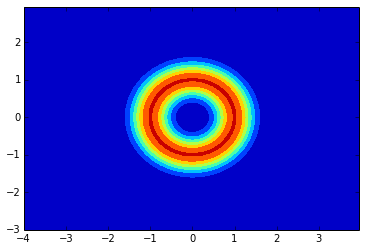

In [42]:
#Example:
delta = 0.05
xs = np.arange(-4.0, 4.0, delta)
ys = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(xs, ys)
p = donut(X,Y,0,0,1.,0.3)
plt.contourf(X,Y,p);

We want to minimise (by picking the right landmark, $i$) the mutual information between what we knew before the next landmark and what we know, now we have the distance to the landmark.

To formalise the mathematics:

- $D_i$ - reported distance from landmark $i$, at location $Z_i$
- $X$ - position of house (where the person is)
- $p(X)$ - current belief in position
- $p(X|D_i)$ - belief in position after getting the reported distance from landmark.
- $p(D_i|X) = N (D_i, ||X-Z_i||, \alpha^2 ||X-Z_i||^2 )$ - the distribution of the distance from a landmark.

The mutual information $I[X;D_i] = H[X] - H[X|D_i]$ needs to be minimised, which, given $H[X]$ is constant over the choice of $i$, is equivalent to maximising the entropy of the distribution once we know the distance to the landmark.

###Objective: Maximise $H[X|D_i]$ over $i$.

First, consider $H[X|D_i]$, for a given $i$ 
(i.e. the conditional entropy of the distribution of house locations given we now know the distance to landmark $i$).

The definition of conditional entropy:

$H[X|D_i] = - E_{D_i} \left[ E_{X|D_i} [ log\; p(X|D_i) ] \right]$

(the expectation over the possible distances of the entropy of $p(X|D_i)$)

Writing this out using summation-notation:

$H[X|D_i] = - \sum_{D_i} p(D_i) \left[ \sum_{X} [\;p(X|D_i)\; log\; p(X|D_i) ] \right]$

Can we calculate this? This is difficult because we having to calculate $p(D_i)$ for every possible value of $D_i$. This would involve finding the proportion of possible locations the person might be (from $p(X)$) for each value of $D_i$. We then also need to recalculate the inner sum's $p(X|D_i)$ each time.

We can use Bayes' rule to rearrange the expression:

$H[X,D_i] = H[X|D_i] + H[D_i] = H[D_i|X] + H[X]$

Rearranging the last equality,

$H[X|D_i] = H[D_i|X] + H[X] - H[D_i]$

Going through each term:

- H[X] is constant over D_i, so we can ignore it
- H[D_i|X] is analytically solved for each X, from a normal distribution
    - $H[D_i|X] = -E_{p(X)}\left[ E_{D_i|X} [log\;p(D_i|X)] \right]$
    - The inner Entropy calculation is of a gaussian with variance $\alpha^2 ||X-Z_i||^2$. The entropy of a normal distribution with such a variance is $ln \left(\alpha\;||X-Z_i||\;\sqrt{2 \pi e} \right)$
- H[D_i] can be found by marginalising over X: $P(D_i) = \int P(D_i|X)\;P(X)\;dX$

The marginalisation loop can be found by sampling some values of $X$ from $P(X)$ - the advantage here is we only need to do this once! Then we can take the gaussian $P(D_i|X)$ and add this to the running integral/summation, to give $P(D_i)$.

![alt text](files/images/marginalising.jpg "")

In [3]:
#H[D_i|X]
#xs, ys = coordinates of prob distribution
#p = prob distribution, of X
#l = coordinates of landmark
#alpha = The standard deviation of the distance estimate is proportional (with factor alpha) to the distance estimate itself
def HofDgivenX(xs,ys,p,l,alpha):
    h = 0 #the entropy (added up over the distribution's area)
    p = p / np.sum(p) #normalise p
    for ix,x in enumerate(xs):
        for iy,y in enumerate(ys):
            #H[D_i|X] = sum(p(X=x) H[Di|X=x])_x
            #H[D_i|X=x] = alpha*||X-l||*sqrt(2*pi*e)            
            h += p[iy,ix] * np.sqrt((x-l[0])**2 + (y-l[1])**2) * alpha*np.sqrt(2*np.pi*np.e)
    return h

#create grid over which the inference will be made.
delta = 0.1
xs = np.arange(-6.0, 6.0, delta)
ys = np.arange(-4.0, 4.0, delta)
X, Y = np.meshgrid(xs, ys)
p = donut(X,Y,0,0,1.,0.3)  #initial distribution, with first landmark at 0,0 with a distance of 1, and alpha=0.3

#marginalising over X: $P(D_i) = \int P(D_i|X)\;P(X)\;dX$
def PofD(xs,ys,p,l,alpha):
    h = 0
    probs = np.zeros(1000)
    delta = 0.1
    mind = 0.
    maxd = 8.
    totalp = np.arange(mind,maxd,delta)*0.
    N = 0
    for ix,x in enumerate(xs):
        for iy,y in enumerate(ys):
            #distance from X to landmark if X is at x,y
            d = np.sqrt((x-l[0])**2 + (y-l[1])**2)
            #handle case of landmark being ontop of X.
            if (d<0.001):
                d = 0.001
            #add P(X) * P(D_i|X)
            totalp += p[iy,ix] * norm.pdf(np.arange(mind,maxd,delta),d,alpha*d)
            N += 1
    totalp = totalp / np.sum(totalp) #TODO: Divide by N or sum(totalp)? - i.e. prob dist. or prob. density dist?
    return totalp

#H[D_i] uses the above calculation of P[D_i], and just uses
#the normal definition of H:
# -sum_d( P[D_i = d] * ln(P[D_i = d]) )
def HofD(xs,ys,p,l,alpha):
    ps = PofD(xs,ys,p,l,alpha)    
    s = 0
    for p in ps:
        if p>0:
            s += p*np.log(p)
    return -s

NameError: name 'donut' is not defined

As an inital example, how does the probability distribution of the distance to a landmark 2km away look?

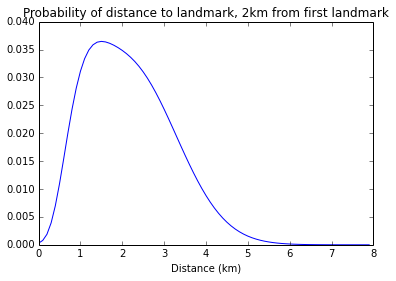

In [44]:
l = [2.,0.]
r = PofD(xs,ys,p,l,.3)
plt.plot(np.arange(0,8,0.1),r);
plt.xlabel('Distance (km)')
plt.title('Probability of distance to landmark, 2km from first landmark');

We can find the entropy of this distribution:

In [45]:
print HofD(xs,ys,p,l,.3)

3.70423904085


How does the uncertainty in the distance affect the optimum distance to maximise the total entropy H[X|D_i]?
In other words, ideally, how far should the 2nd landmark be from the first, as our confidence in the distance from the first varies?

In [1]:
alphas = [0.025,0.05,0.1,0.15,0.2,0.4,0.7]
results = [];
for alpha in alphas:
    print alpha
    xvals = np.arange(0.,3.,0.1);
    vals = np.zeros_like(xvals)
    temp_hofd = np.zeros_like(xvals)
    temp_hofdgivenX = np.zeros_like(xvals)
    for i,xv in enumerate(xvals):
        l = [xv,0.]
        temp_hofd[i] = HofD(xs,ys,p,l,alpha)
        temp_hofdgivenX[i] = HofDgivenX(xs,ys,p,l,alpha)
        vals[i] = temp_hofdgivenX[i] - temp_hofd[i]
    results.append(xvals[np.argmax(-vals)])

0.025


NameError: name 'np' is not defined

The relationship is surprisingly linear, and follows a reasonable intuition. If the donuts were narrow (i.e. alpha is small) we minimise the overlap by picking a 2nd landmark a considerable distance away (making the donuts overlap at right-angles). If we are uncertain, i.e. alpha is large, the donuts are fat, and having a landmark a long way away will cause the very wide donut ring to provide little extra information about the person's location.

It might also seem counter intuitive that the best location for alpha=0.7 is at zero (also there might be numerical innaccuracies due to the finite number of samples of X): One might feel that wouldn't give any additional information. However we assume (probably wrongly) that the errors in the estimate of $D_i$ for each landmark are independent, so a second estimate at the same location will give us information.

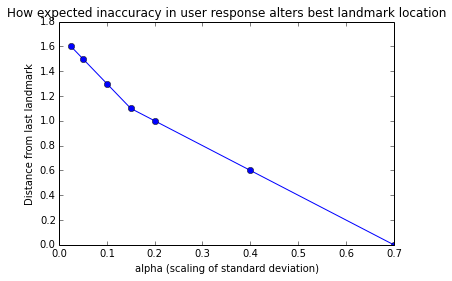

In [47]:
plt.plot(alphas,results,'o-')
plt.xlabel('alpha (scaling of standard deviation)')
plt.ylabel('Distance from last landmark')
plt.title('How expected inaccuracy in user response alters best landmark location')

To finish, below I've plotted each of the above points, from alpha values low to high, to illustrate why these distances are optimum. The actual distance to the landmark is the mode of the probability distribution (i.e. most likely distance).

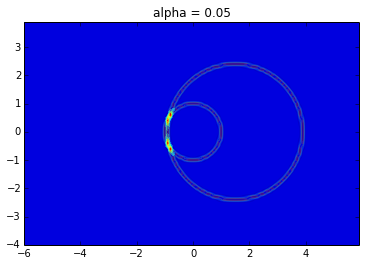

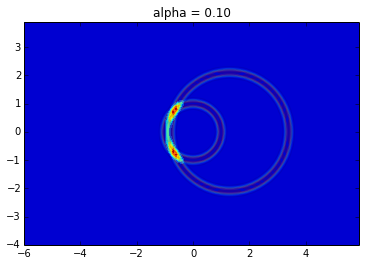

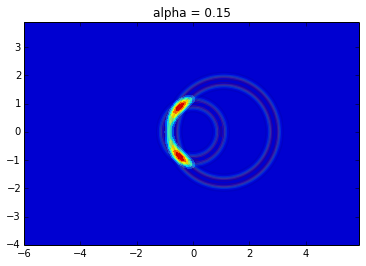

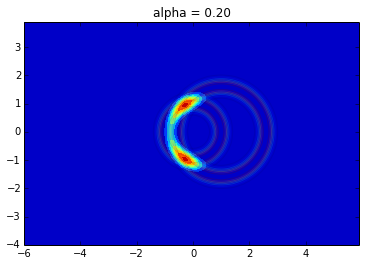

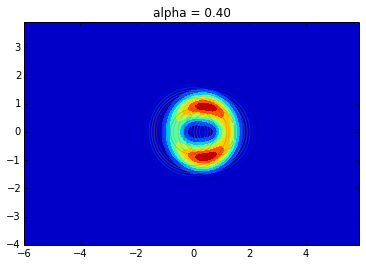

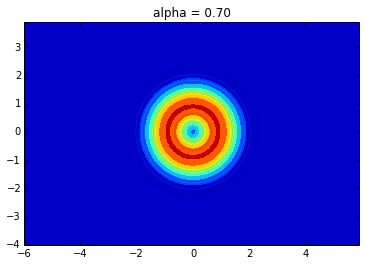

In [49]:
for r,a in zip(results[1:],alphas[1:]):
    p = donut(X,Y,0,0,1.,a)
    circs = PofD(xs,ys,p,[r,0],a)
    dists = np.arange(0,8,0.1)
    dist = dists[np.argmax(circs)]
    q = donut(X,Y,r,0,dist,a)
    z = p*q
    z = (z / np.sum(z))/(delta**2)
    plt.contourf(X, Y, z)
    plt.contour(X, Y, p,alpha=0.2,N=3)
    plt.contour(X, Y, q,alpha=0.2,N=3)
    plt.title('alpha = %0.2f' % a)
    plt.figure()